Associate AI Engineer Technical Test Jul 2024
> Alyssa Ang 90273115
alysappleseed@gmail.com

# Exploratory Data Analysis (EDA) for Olist

### Background
Olist is a Brazilian e-commerce marketplace, connecting small retailers with customers. A customer can place a purchase order for multiple items from a vast selection of sellers on Olist. The sales order will then be fulfilled by a logistic partner. Anonymized data consists of order information for about 100k orders from
year 2016 to 2018.

### Objective
Determining who are Olist's high value loyal customers, such that the business can design and deploy more effective and targeted marketing campaigns. Predict potential repeat buyers.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy import stats
import seaborn.objects as so
import re
import geopandas as gpd

## 1. Initial Analysis on Dataset

Prior data cleaning has been done in the init_dataCleaning.py pipeline to ensure quality analysis in this portion of the EDA and downstream processes. The data cleaning steps included:
- Handling missing values, and inconsistencies
- Mitigate any erronous data that may cause pitfalls and inaccurate analysis
- Performing data transformation with feature engineering by creating new columns, aggregating, and categorizing to reduce dimensionality of the dataset
- Ease of analysis and reduces the need for further cleaning in this portion is not required
- Merging core and secondary datasets to create a new MAIN dataset
- Created a secondary dataset geodata to analyse customer and seller geolocation data

Additionally, there were columns that were dropped prior in cleaning
- Do not contribute towards the analysis, visualization, and model 
- Purely description-based that do not provide further information
- Used to create new columns

Though, dropping columns early on is not recommended; having more features increases the dimensionality, imputation for missing values for columns that do not contribute is requires mores resources. Other columns that should be dropped will be dropped in feature selection after univariate and bivariate analysis


From this initial data cleaning step, I was able to gain prior insights to the dataset that would help me form better assumptions and questions in this portion of EDA. Generally the data is very skewed, which that can be attributed to the nature of e-Commerce platforms where they face one-time buyer problem. Through analysis and leveraging ML models, platforms can better cater to customers and operational efficiency.

In [61]:
# Main dataset
df = pd.read_csv("main")

# Secondary dataset for customer and seller geodata
geodf = pd.read_csv("geodata")

In [3]:
df.head()

,order_id,customer_id,order_status,customer_purchase_month,customer_purchase_year,order_lifecycle,order_estimated_lifecycle,order_approved_days,order_to_logs_days,total_items,...,total_payment_value,total_sequences,total_reviews,review_score,review_comment_title,review_comment_message,answer_days_taken,customer_unique_id,customer_state,customer_purchase_count
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10,2017,8,15,0,2,1,...,38.71,3,1.0,4.0,0.0,3.0,1.0,7c396fd4830fd04220f754e42b4e5bff,SP,2
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,7,2018,13,19,1,1,1,...,141.46,1,1.0,4.0,1.0,1.0,0.0,af07308b275d755c9edb36a90c618231,BA,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,8,2018,9,26,0,0,1,...,179.12,1,1.0,5.0,0.0,0.0,4.0,3a653a41f6f9fc3d2a113cf8398680e8,GO,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,11,2017,13,26,0,3,1,...,72.20,1,1.0,5.0,0.0,3.0,2.0,7c142cf63193a1473d2e66489a9ae977,RN,1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2,2018,2,12,0,0,1,...,28.62,1,1.0,5.0,0.0,0.0,1.0,72632f0f9dd73dfee390c9b22eb56dd6,SP,1


In [4]:
geodf.head()

,order_id,customer_id,customer_unique_id,customer_state,customer_lat,customer_lng,seller_id,seller_state,seller_lat,seller_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,SP,-23.155435,-47.084152,3504c0cb71d7fa48d967e0e4c94d59d9,SP,-23.155435,-47.084152
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,BA,-13.053056,-39.562863,289cdb325fb7e7f891c38608bf9e0962,SP,-23.155435,-47.084152
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,GO,-16.577645,-49.334195,4869f7a5dfa277a7dca6462dcf3b52b2,SP,-23.155435,-47.084152
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,RN,-5.856702,-35.990079,66922902710d126a0e7d26b0e3805106,MG,-19.865373,-44.420766
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,SP,-23.155435,-47.084152,2c9e548be18521d1c43cde1c582c6de8,SP,-23.155435,-47.084152


In [5]:
df.shape

(96477, 32)

There are a total of 96477 orders in dataset, with 32 features; excluding adoption speed.
Each unique customer has a unique customer_unique_id, atop additional information such as order_id, customer_id, order_status, etc. Which are important attributes to each customer, and for understanding their purchases. There are binned features that help simplify, and categorize. During the initial data cleaning stage, it was decided to only consider orders that have already been "delivered" order_status as it is the most accurate metric, in comparison to other statuses, like approved, which could be lost in transit at the next checkpoint of the purchase.

In [6]:
df.describe() # Derive a comprehensive summary 

,customer_purchase_month,customer_purchase_year,order_lifecycle,order_estimated_lifecycle,order_approved_days,order_to_logs_days,total_items,total_sellers_in_order,distance_km,total_price,...,product_volume,total_installments,total_payment_value,total_sequences,total_reviews,review_score,review_comment_title,review_comment_message,answer_days_taken,customer_purchase_count
count,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,...,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,95831.000000,96477.000000,95831.000000,95831.000000,96477.000000
mean,6.031085,2017.544347,12.093121,23.372814,0.264301,2.736155,1.142179,1.142179,533.702722,137.041607,...,15143.166019,2.928045,159.856357,1.045140,0.998787,4.155628,0.115976,0.703269,2.577819,1.075728
std,3.228394,0.503538,9.550155,8.758166,0.729883,3.641199,0.538773,0.538773,616.699091,209.046281,...,23218.207406,2.712705,218.813144,0.370628,0.110728,1.283985,0.320198,0.990660,9.794922,0.374278
min,1.000000,2016.000000,0.000000,2.000000,0.000000,-172.000000,1.000000,1.000000,0.000000,0.850000,...,168.000000,1.000000,9.590000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,2017.000000,6.000000,18.000000,0.000000,1.000000,1.000000,1.000000,0.000000,45.900000,...,2816.000000,1.000000,61.880000,1.000000,1.000000,4.000000,0.000000,0.000000,1.000000,1.000000
50%,6.000000,2018.000000,10.000000,23.000000,0.000000,2.000000,1.000000,1.000000,427.000000,86.570000,...,6400.000000,2.000000,105.280000,1.000000,1.000000,5.000000,0.000000,0.000000,1.000000,1.000000
75%,8.000000,2018.000000,15.000000,28.000000,0.000000,4.000000,1.000000,1.000000,818.000000,149.900000,...,18200.000000,4.000000,176.330000,1.000000,1.000000,5.000000,0.000000,1.000000,3.000000,1.000000
max,12.000000,2018.000000,209.000000,155.000000,30.000000,125.000000,21.000000,21.000000,3311.000000,13440.000000,...,296208.000000,24.000000,13664.080000,26.000000,3.000000,5.000000,1.000000,3.000000,518.000000,15.000000


In [7]:
df.columns # Look at features of dataset

Index(['order_id', 'customer_id', 'order_status', 'customer_purchase_month',
       'customer_purchase_year', 'order_lifecycle',
       'order_estimated_lifecycle', 'order_approved_days',
       'order_to_logs_days', 'total_items', 'total_sellers_in_order',
       'product_category_name', 'seller_state', 'distance_km', 'total_price',
       'total_freight_cost', 'product_photos_qty', 'product_name_lenght',
       'product_description_lenght', 'product_volume', 'payment_types',
       'total_installments', 'total_payment_value', 'total_sequences',
       'total_reviews', 'review_score', 'review_comment_title',
       'review_comment_message', 'answer_days_taken', 'customer_unique_id',
       'customer_state', 'customer_purchase_count'],
      dtype='object')

In [62]:
print("Missing Values in Dataset")
print()
# Check for null values in each dataset
missingData = df.isnull().sum()
missingCol = missingData[missingData > 0]
if not missingCol.empty:
    print(missingCol) 

Missing Values in Dataset

review_score              646
review_comment_message    646
answer_days_taken         646
dtype: int64


There are missing review scores, messages and number of days taken to answer as some customers may not leave a review. This missing data will not be imputed due to the low proportion.

"purchase_cat" categorization for easier analysis

0 for one-time buyers, 1 for two-time buyers, 2 for 3-6 purchases made, 3 for 7 or more purchases made

In [63]:
# Denoted by levels ranging from 0-3
def cat_length(amount):
    if amount == 1:
        return 0
    elif amount == 2:
        return 1
    elif 3 <= amount <= 6:
        return 2
    else:
        return 3
def cat_purchase(amount):
    if amount == 1:
        return 0
    else:
        return 1
    
# Avoid warning
df = df.copy()
# New cols to categorize the amount of purchases made by customer
df['purchase_cat'] = df.customer_purchase_count.apply(cat_length)
df['repurchasedorNO'] = df.customer_purchase_count.apply(cat_purchase)

In [10]:
# Plot correlation map with specific datasets, and columns
def plotCorrMap(df, cols, title, ax):
    # Choose specific features to correlate
    corr = df[cols].corr(numeric_only=True)

    # Plot the correlation map
    plt.figure(figsize=(5,3))
    sns.heatmap(corr, annot=True, cmap='coolwarm', annot_kws={"size": 10}, ax=ax)
    ax.set_title(f"Correlation Map {title}")

In [11]:
# Set theme for graphs
sns.set_theme(style="ticks", palette="Set2")

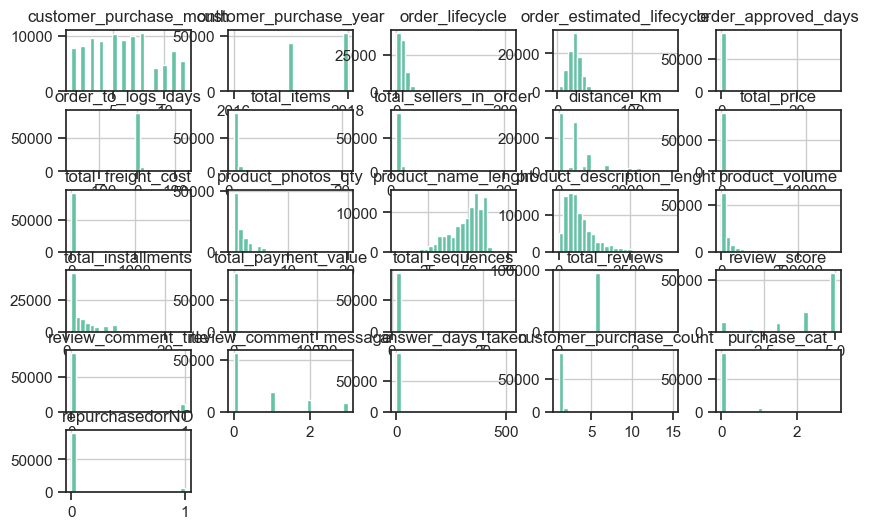

In [12]:
# Shows overall distibution of each column
df.hist(bins=25,figsize=(10,6)) # Plot histogram
plt.show()

Can be seen that generally, the features are skewed in nature, low distribution across and data points occurring in the tails of the distribution. Seems to have many extreme outliers, as majority of distribution is located at the head.
- Essential to consider how skewness and distribution may influence relationships and the overall insights derived from the data
- Bias or relationship?

## 2. Univariate Analysis on Dataset
Individual analysis on attributes

#### Functions

In [13]:
# Functions that return percentages
def calculate_univariate_percentages(df, x):
    # Calculate total counts for each unique value in column x
    totalCounts = df[x].value_counts().to_dict()
    # Calculate percentages
    total_rows = len(df)
    percentages = {k: f"{round((v / total_rows) * 100, 3):.3f}%" 
                   for k, v in totalCounts.items()}
    return percentages

def calculate_pairwise_percentages(df, x, hue):
    # Calculate total counts for each unique value in x and hue
    counts = df.groupby([hue, x]).size().unstack(fill_value=0)
    
    # Calculate percentages for each category in hue (TypeName)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    return percentages

def calculate_count_percentages(df, x, col):
    # Calculate total counts (sum of all values in column x)
    totalCounts = df[x].sum()
    
    # Calculate percentages
    percentages = {row[col]: f"{(row[x] / totalCounts) * 100:.3f}%" 
                   for index, row in df.iterrows()}
    
    return percentages

In [14]:
# Functions that deal with graphs and visualizations
def setTitleLabels(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
# Plots a table beside graph
def plotTable(ax, table_data):
    # Convert dictionary to a list of lists for Matplotlib table
    table_data_list = [[key, value] for key, value in table_data.items()]

    # Add the table to the plot and adjust size
    table = ax.table(cellText=table_data_list, loc='right', bbox=[1.1, 0.2, 0.99, 0.7])
    return table
    
# Plots histograms and annotates with counts accordingly
def plotHist(df, x, hue, title, xlabel, ylabel, table_data ,remove_legend=True):
    # Plot barplots
    plt.figure(figsize=(7, 4))
    ax = sns.histplot(data=df, x=x, hue=hue, 
                      multiple="dodge", palette="pastel", label="legend")
    
    # Calculate values manually
    totalCounts = df[hue].value_counts().to_dict()
    
    # Annotate each bar
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:  # Only annotate bars with a height greater than 0
            ax.annotate(f'{height:.0f}', 
                        xy=(patch.get_x() + patch.get_width() / 2, height), 
                        xytext=(0, -3),
                        textcoords="offset points", 
                        ha='center', va='bottom', fontsize=10, color='black', weight='bold')

    # Set the title and labels
    setTitleLabels(title, xlabel, ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a faint grid for readability 
    ax.set_ylim(0, max(df[hue].value_counts()) + 3000)
    
    # Plot a table within the graph to show data
    plotTable(ax, table_data)
    if remove_legend:
        ax.legend().remove()
    plt.show()
    
# Plots BoxPlots
def plotBoxPlot(list_table, df, x, y, hue, title, xlabel, ylabel):
    # Create boxplot
    plt.figure(figsize=(7, 3))
    ax = sns.boxplot(data=df, x=x, y=y, hue=hue, width=0.5)
    if hue is not None:
        plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    if list_table is not None:
        plotTable(ax, list_table)
    # Add labels and title
    setTitleLabels(title, xlabel, ylabel)
    plt.show()
    
def plotReplot(df, x, y, hue, size, title):
    sns.relplot(x=x, y=y, 
                hue=hue, size=size,
                sizes=(40, 400), alpha=0.15, palette="muted",
                height=4, aspect=4, data=df)
    plt.title("Relationship between Distance (km), Repurchase Status, and Order Lifecycle")
    plt.show()

In [15]:
# Used for pd.Series dtypes (categorized cols)
def extract_unique_categories(df, col, col_name1, col_name2):
    category_names = {}
    x = df[col]
    unique_categories = set()
    pattern = r"'([^']+)'"
    for item in x:
        categories = re.findall(pattern, item)
        unique_categories.update(categories)
    for category_name in unique_categories:
        # Create mask for current category
        mask = df[df[col].apply(lambda x: category_name in x)]
        count_counts = mask.value_counts().value_counts().iloc[0]

        # Update the dictionary with the count counts
        category_names[category_name] = count_counts

    # Convert dictionary to DataFrame
    catnames = pd.DataFrame(list(category_names.items()), columns=[col_name1, col_name2])
    return catnames

### Distribution of customers

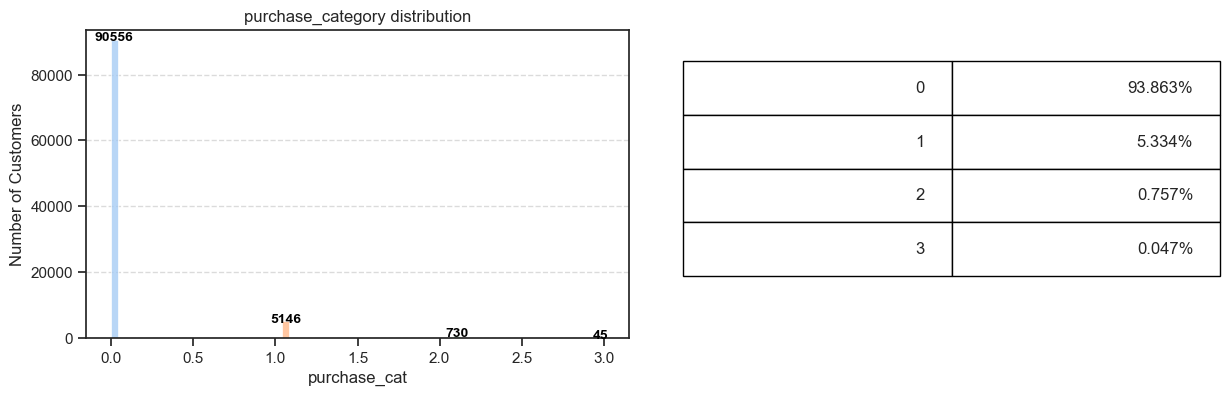

In [16]:
percentages = calculate_univariate_percentages(df, "purchase_cat")
plotHist(df, "purchase_cat", "purchase_cat","purchase_category distribution", 
         "purchase_cat", "Number of Customers", percentages)

Looking deeper,

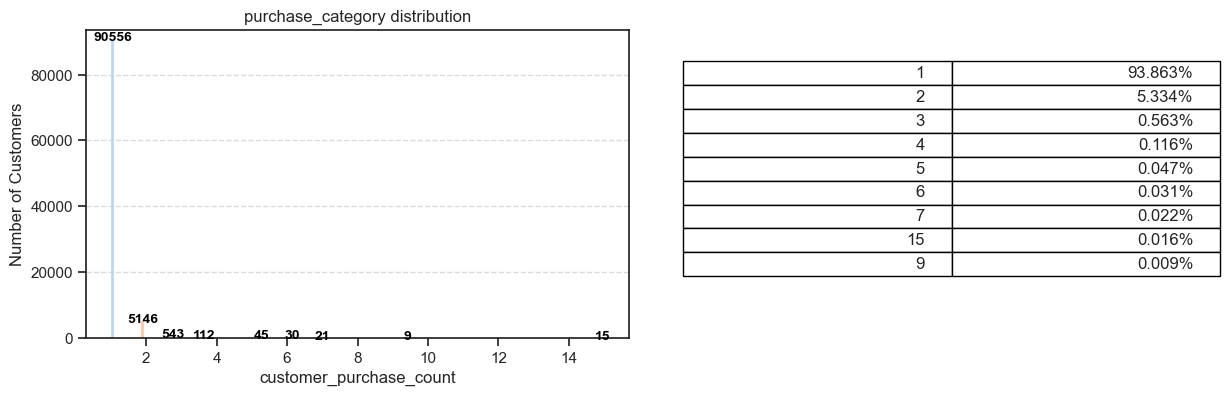

In [17]:
percentages = calculate_univariate_percentages(df, "customer_purchase_count")
plotHist(df, "customer_purchase_count", "customer_purchase_count","purchase_category distribution", 
         "customer_purchase_count", "Number of Customers", percentages)

Can be seen that the platform severely faces a one-buyer problem where majority of customers are one-time buyers 93.863%, with repeat buyers making only ~6% of the total. It is extremely rare for customers to repurchase on Olist more than 3 times, only making up ~1%. Highest amount of repurchases is 15 times, by 15 customers

### Distribution of prices, freight cost, and total payment value

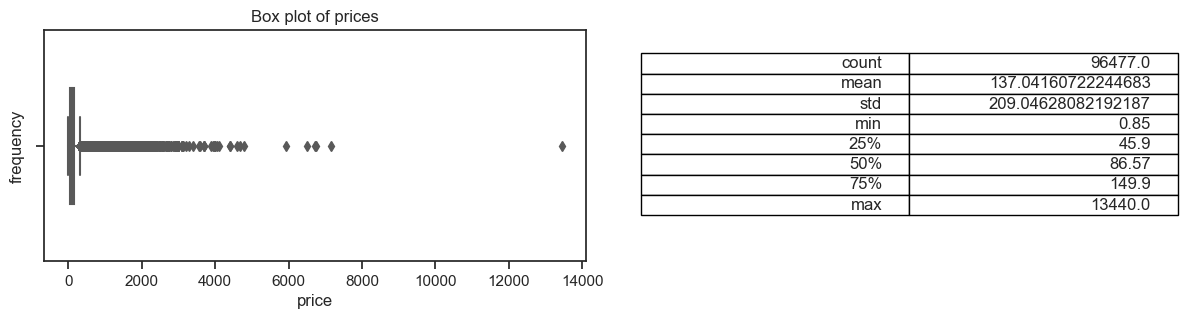

In [18]:
statistics = df['total_price'].describe().to_dict()
plotBoxPlot(statistics, df, "total_price", None, None, 
            "Box plot of prices", "price", "frequency")

Shows that generally, customers prefer to purchase cheaper items, however, there are customers who make very expensive purchases which cause extreme outliers in the price. On average, customers are making purchases of $137 per order.

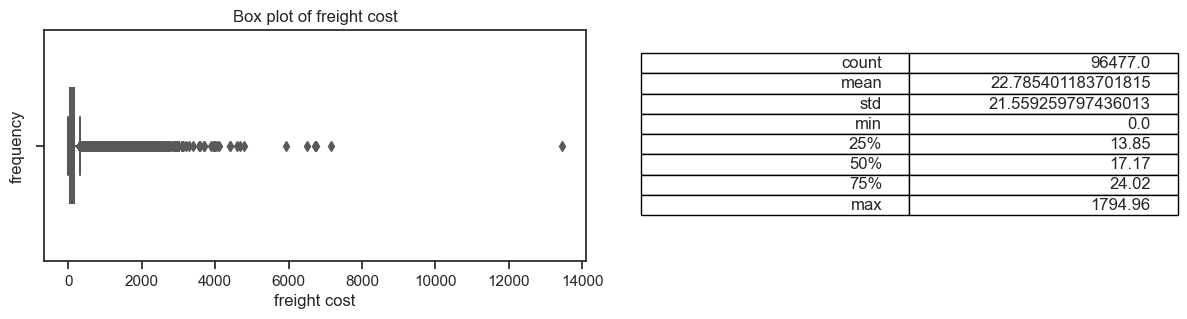

In [19]:
statistics = df['total_freight_cost'].describe().to_dict()
plotBoxPlot(statistics, df, "total_price", None, None, 
            "Box plot of freight cost", "freight cost", "frequency")

Not much difference in the 25th, 50th, and 75th quartile, however, there is a charge of $1794 which is an outlier from the general cost 

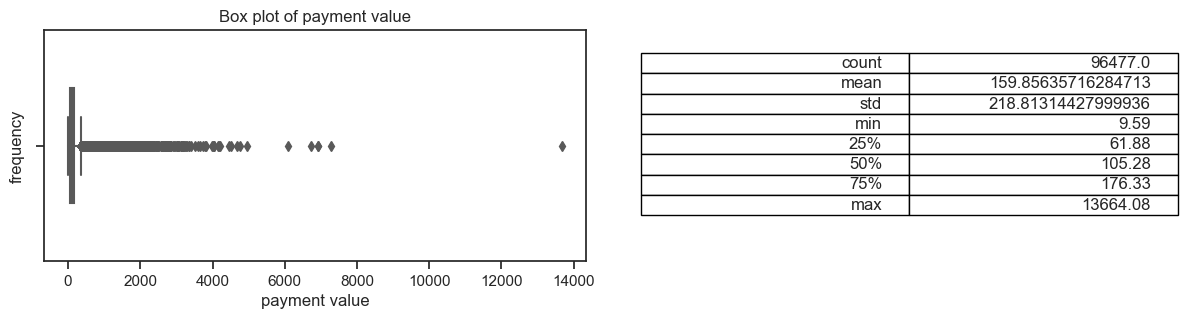

In [20]:
statistics = df['total_payment_value'].describe().to_dict()
plotBoxPlot(statistics, df, "total_payment_value", None, None, 
            "Box plot of payment value", "payment value", "frequency")

As payment value is the sum of price, and freight cost, it has the same general shape across the three.
- Generally, customers like to buy cheaper products, however, with freight included, the cheapest purchase made was $9.59.
- The most expensive purchase made cost 13664, but the most expensive total price is 13440.
- The avg freight cost is higher than avg price.

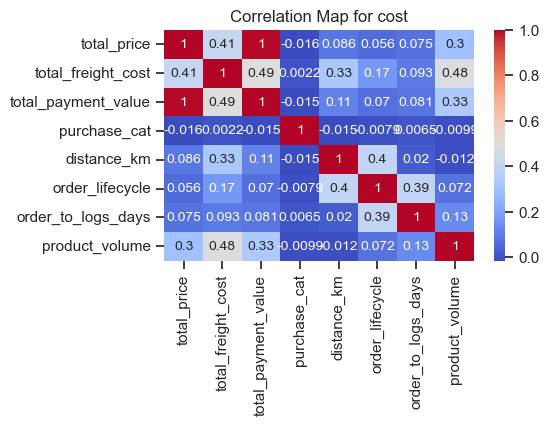

<Figure size 500x300 with 0 Axes>

In [21]:
# Look at cols that would likely attribute
df_costs = df[['order_id','total_price',
               'total_freight_cost','total_payment_value',
               'purchase_cat','distance_km','order_lifecycle',
               'order_to_logs_days','product_volume']]
# Plot correlation map
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
plotCorrMap(df_costs, df_costs.columns, "for cost", axs)

Looking at this correlation map,
- Product volume has the highest high positive correlation with freight cost (0.48), price (0.3) - the bigger the product, the higher the freight cost, and price
- Distance between the seller and customer has high positive correlation (0.33) with freight cost
- Purchase category mostly has low to negligible negative correlation which could denote orders that are cheaper, faster, and smaller, and have longer handling times are more likely to be repurchased

### Distribution of product size

In [22]:
# Init the bins accordingly
bin_edges = [0, 1000, 10000, 100000, float('inf')] 
bin_labels = ['s', 'm', 'l', 'xl']

# Bin the product_size column
df['volume_bins'] = pd.cut(df['product_volume'], 
                           bins=bin_edges, labels=bin_labels)

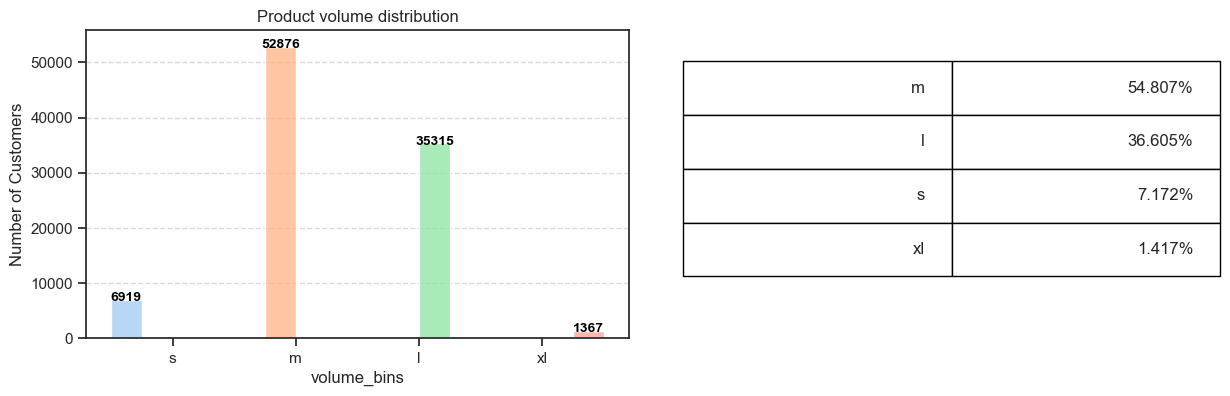

In [23]:
percentages = calculate_univariate_percentages(df, "volume_bins")
plotHist(df, "volume_bins", "volume_bins","Product volume distribution", 
         "volume_bins", "Number of Customers", percentages)

Product volume is the median volume of item purchased by customer

Majority of purchases fall under m (54.8%), followed by l (36.6%), and the least amount of xl (1.41%) in volume. Considering volume can be useful as larger items with higher volumes usually require more packaging material, occupy more space, and higher freight.

In [82]:
# Look at the lowest 20
# Create an aggregated dataset to be used with plots
prod_purchase = df.groupby(['purchase_cat', 
                         ]).agg({'product_photos_qty': 'mean',
                                 'product_name_lenght': 'mean',
                                 'product_description_lenght': 'mean',
                                 'customer_purchase_count':'mean'
                                }).reset_index()
prod_purchase

,purchase_cat,product_photos_qty,product_name_lenght,product_description_lenght,customer_purchase_count
0,0,2.243838,48.892509,794.056446,1.000000
1,1,2.048873,49.074718,734.237466,2.000000
2,2,2.158904,49.006164,770.493836,3.400000
3,3,2.211111,46.311111,418.800000,10.066667


- Positive correlation between product name length and description length
- There is no clear trend indicating a direct relationship between photos quantity and customer purchase count
- For customers who repeat purchase >7 times tend to purchase more items within the same purchase, and factors such as product name and description do not affect much due to the low avg description and name length.
- One-time buyers tend to buy products with longer product_description lengths

### Distribution of product categories

Offering a diverse variety of products enhances choice and empowers customers during their online shopping experiences. However, not all categories may be equally favoured.

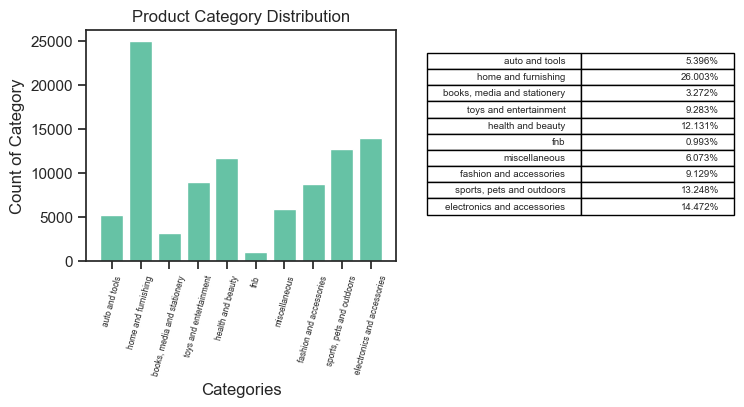

In [24]:
# Get counts, and percentages to plot
product_cat_counts = extract_unique_categories(df, 'product_category_name',
                                               'Category','Count')
percentages = calculate_count_percentages(product_cat_counts, 
                                          'Count', 'Category')

# Plot bargraph
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(product_cat_counts.Category, product_cat_counts.Count)
plotTable(ax, percentages)
setTitleLabels("Product Category Distribution","Categories","Count of Category")
plt.xticks(rotation=75, fontsize=6)
plt.show()

Home and furnishing is the highest total orders, sitting at 26%, followed by electronics and accessories 14.4%, next, sports, pets and outdoors. The lowest being fnb 0.99% and books, media and stationery.

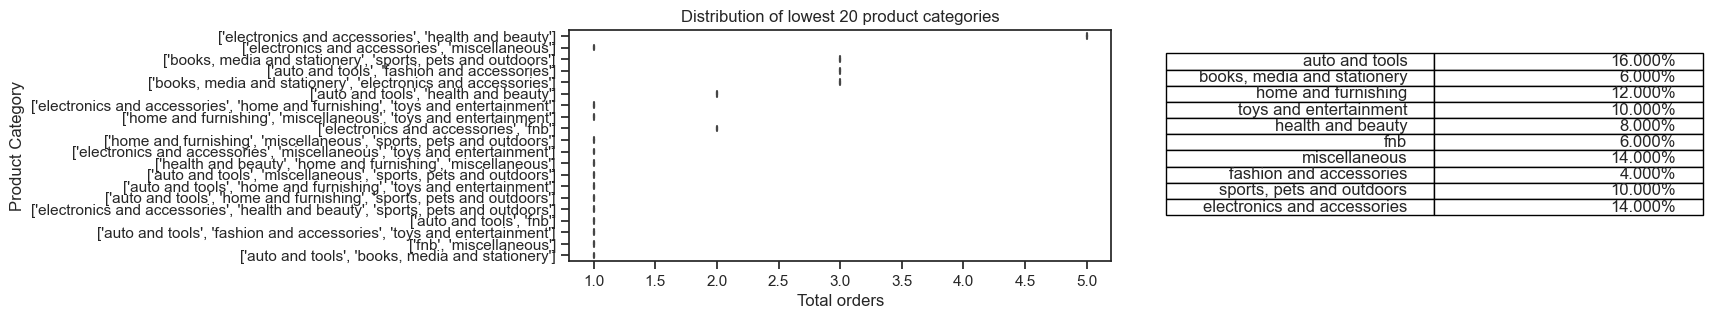

In [25]:
# Look at the lowest 20
# Create an aggregated dataset to be used with plots
prod_cat_agg = df.groupby(['product_category_name', 
                         ]).agg({'total_items': 'sum',
                                 'repurchasedorNO': 'sum',
                                 'order_id': 'count',
                                 'purchase_cat': 'first'
                                }).reset_index()
lowest_20 = prod_cat_agg.sort_values(by='total_items', 
                                     ascending=False).tail(20)
cat_counts = extract_unique_categories(lowest_20, "product_category_name", 
                                       "cat", "count")
percentages = calculate_count_percentages(cat_counts, 'count', 'cat')

# Plot boxplot
plotBoxPlot(percentages, lowest_20,"order_id","product_category_name", None,
            "Distribution of lowest 20 product categories",
            "Total orders","Product Category")

Do consumers prefer to purchase from one category only? The lowest 20 show that majority of the purchases are from different categories. Most purchases are from auto and tools 16%, followed by miscellaneous category 14% and home and furnishing still being one of the more popular choices.

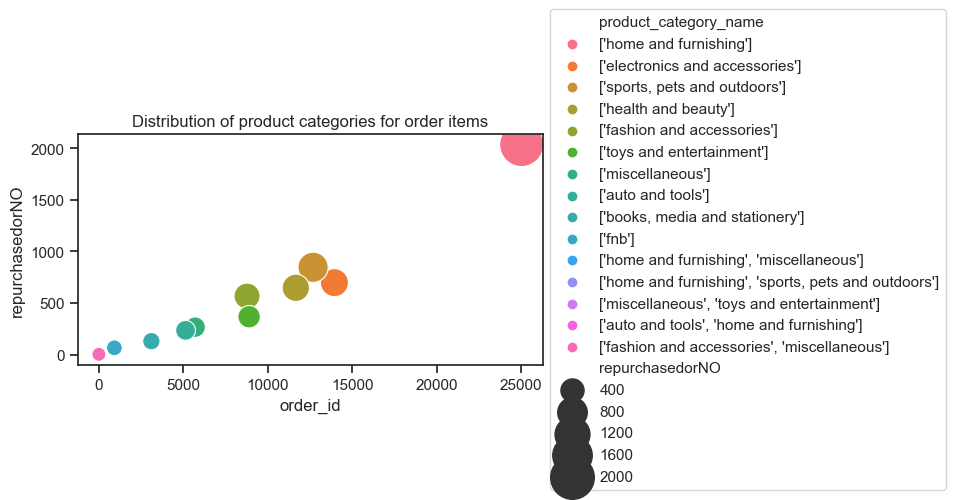

In [26]:
# Looking at the top 15
top_15 = prod_cat_agg.sort_values(by='total_items', 
                                  ascending=False).head(15)
fig, ax = plt.subplots(figsize=(6, 3))
# Scatterplot to plot betweem relationships
sns.scatterplot(ax=ax, data=top_15, x="order_id", 
                y="repurchasedorNO", hue="product_category_name",
                size='repurchasedorNO', sizes=(100, 1000))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Distribution of product categories for order items")
plt.show()

Majority of repurchases were under home and furnishing, followed by electronics and accessories. 
- More repurchases are made when it is a popular category
- Customers prefer home and furnishing, electronics and accessories and sports, pets and outdoors
- FnB has lowest repurchase rates, and lowest popularity amongst customers
- Customers prefer to purchase multiple and repurchase from single category

### Distribution of reviews

Reviews are crucial because they provide valuable insights for others to evaluate and better understand a product, higher reviews increase customer trust and confidence in products offered, leading to potential increases in sales and customer satisfaction.

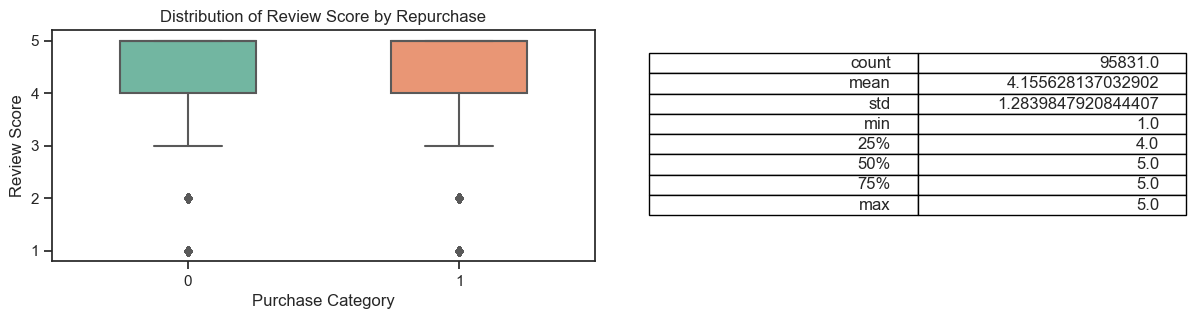

In [27]:
statistics = df['review_score'].describe().to_dict()
plotBoxPlot(statistics, df,"repurchasedorNO","review_score", None,
            "Distribution of Review Score by Repurchase",
            "Purchase Category","Review Score")

Looks like majority of customers are very satisfied, with an avg of ~4 as their review score.
- Which factors contribute towards a low or high rating?

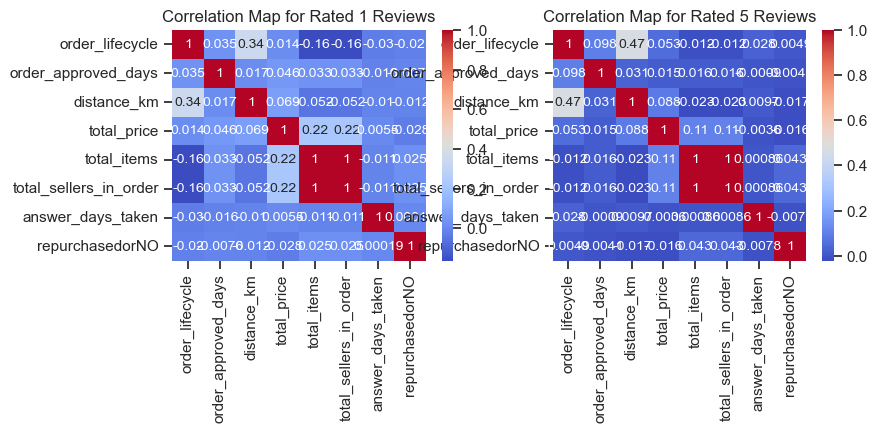

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

In [28]:
# Get df for low and high review scores
low_review_score = df[df['review_score']==1]
high_review_score = df[df['review_score']==5]

# Filter to columns that most likely attribute to review score
columns = ['order_lifecycle', 'order_approved_days',
           'distance_km', 'total_price','total_items',
           'total_sellers_in_order','payment_types', 
           'answer_days_taken', 'repurchasedorNO']

# Plot correlation maps
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
plotCorrMap(low_review_score, columns, "for Rated 1 Reviews", axs[0])
plotCorrMap(high_review_score, columns, "for Rated 5 Reviews", axs[1])
plt.show()

- Longer order lifecyle and further distance is more favoured
- Cheaper items are more likely to have higher reviews
- The more sellers, and items warrant for a lower score
- Looks like repurchases are not often even with low or high score made due to the low correlation

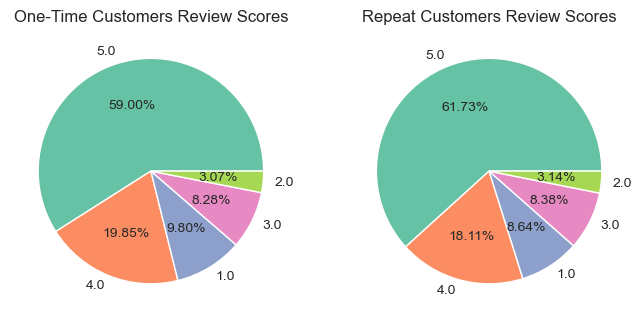

In [29]:
# Get counts
df_no = df[df['repurchasedorNO']==0]
df_yes = df[df['repurchasedorNO']==1]
repeat_counts = df_yes['review_score'].value_counts()
one_counts = df_no['review_score'].value_counts()

# Create a pie chart
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

# Pie chart for one-time customers
ax[0].pie(one_counts, labels=one_counts.index, 
          autopct='%1.2f%%', textprops={'fontsize': 10})
ax[0].set_title('One-Time Customers Review Scores')

# Pie chart for repeat customers
ax[1].pie(repeat_counts, labels=repeat_counts.index, 
          autopct='%1.2f%%', textprops={'fontsize': 10})
ax[1].set_title('Repeat Customers Review Scores')
plt.show()

Generally the same distribution between one-time and repeat-buyers

### Distribution of payment types

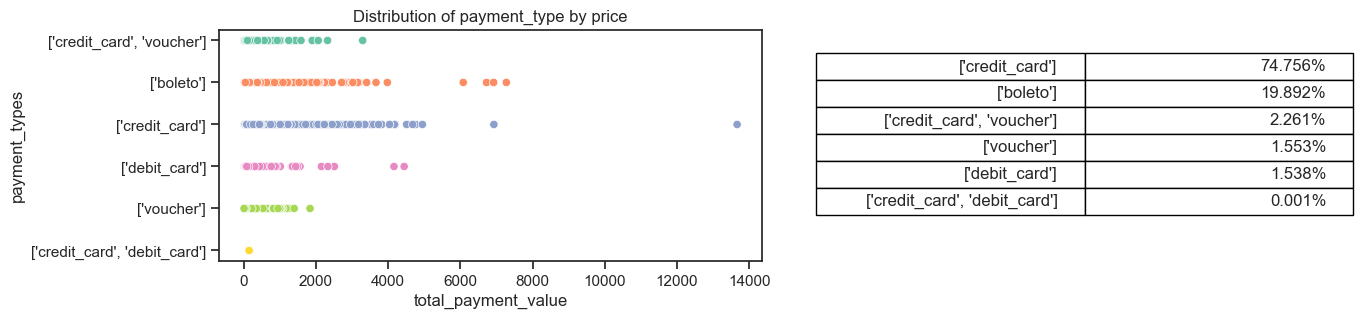

In [30]:
plt.figure(figsize=(7, 3)) 

# Scatterplot to plot betweem relationships
ax = plt.gca()
sns.scatterplot(data=df, x="total_payment_value", 
                y="payment_types", hue="payment_types")
percentages = calculate_univariate_percentages(df, 'payment_types')
plotTable(ax, percentages)
ax.get_legend().remove()
plt.title("Distribution of payment_type by price")
plt.show()

Majority of customers prefer to pay by credit card 74.756%, and debit card is the least ~1.538%. 

## 3. Bivariate and Multivariate Analysis on Dataset
Pairwise and multi analysis on attributes

### Relationships with location

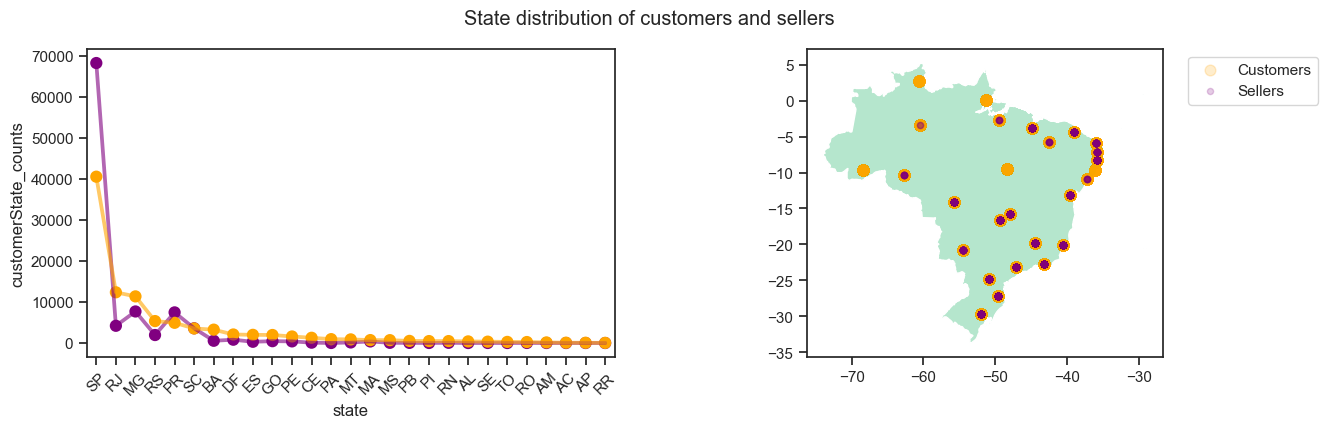

In [31]:
# Firstly get total seller counts of each state
seller_state_counts = extract_unique_categories(df, 'seller_state', 
                                                'state', 'sellerState_counts')
# Next, get total custtomer counts of each state
state_counts = df['customer_state'].value_counts()

# Create a DataFrame from value counts for plotting
state_counts_df = state_counts.reset_index()
state_counts_df.columns = ['state', 'customerState_counts']
# Merge to get a cohesive df to work with
merge_state_counts = pd.merge(state_counts_df, seller_state_counts, 
                              on='state', how='left').fillna(0)
# Plot pointplot for visualization
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.pointplot(data=merge_state_counts, x='state', y='sellerState_counts', 
              color='purple', label='seller', ax = axs[0])
sns.pointplot(data=merge_state_counts, x='state', y='customerState_counts', 
              color='orange', label='customer', ax = axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

#Add transparency
for line in axs[0].lines:
  line.set_alpha(0.6)

# Load geopandas file, and convert geodata into geo dataframes
world = gpd.read_file('ne_10m_admin_0_countries.shp')
customer_gdf = gpd.GeoDataFrame(geodf, 
                                geometry=gpd.points_from_xy(geodf['customer_lng'], geodf['customer_lat']))
seller_gdf = gpd.GeoDataFrame(geodf, 
                              geometry=gpd.points_from_xy(geodf['seller_lng'], geodf['seller_lat']))
# Get Brazil
brazil = world[world.SOVEREIGNT=='Brazil']

# Plot Brazil
brazil.plot(ax=axs[1], color='#b5e6cd')
# Plot for customers and sellers on map
customer_gdf.plot(ax=axs[1], color='orange', markersize=60, label='Customers', alpha=0.2)
seller_gdf.plot(ax=axs[1], color='purple', markersize=20, label='Sellers', alpha=0.2)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle("State distribution of customers and sellers")
plt.show()

- Most sellers and customers reside in SP
- In MG, more customers reside in that state than sellers
- In PR, more sellers have operations in that state than customers
- Five states have no sellers -> AL, TO, RO, AC, AP
- Concentrated towards the edges

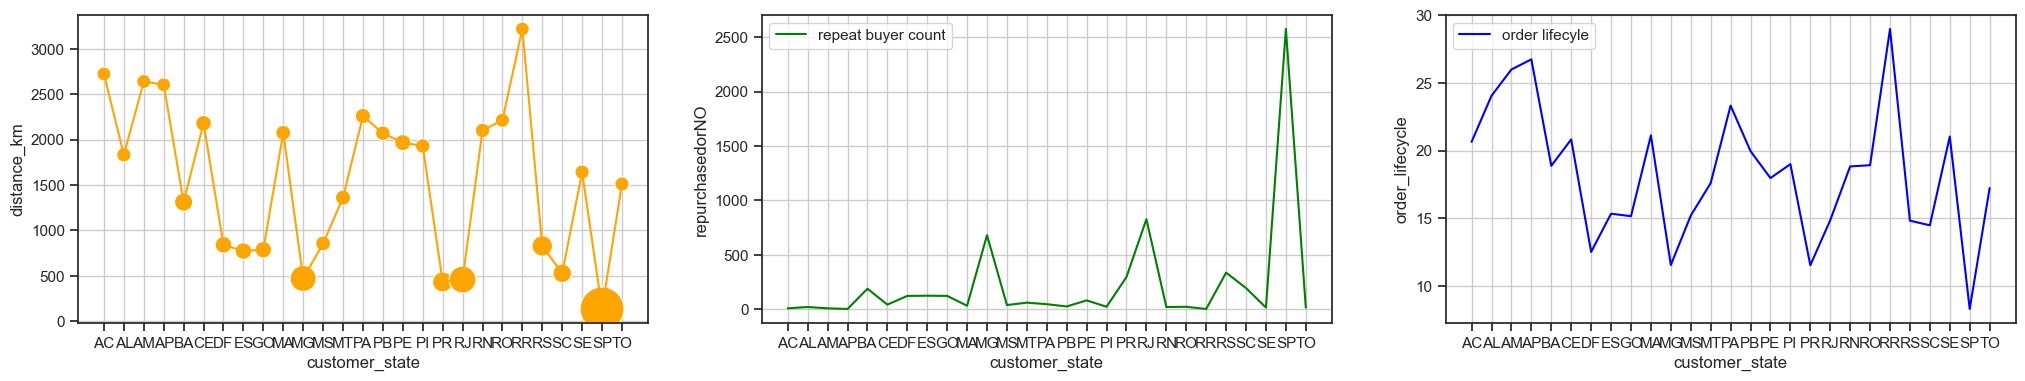

In [32]:
dist_agg = df.groupby(['customer_state', 
                         ]).agg({'distance_km': 'mean',
                                 'repurchasedorNO': 'sum',
                                 'order_id': 'count',
                                 "order_lifecycle": 'mean'
                                }).reset_index()
fig, ax = plt.subplots(1, 3, figsize=(25, 4))
sns.lineplot(ax=ax[0], data=dist_agg, x='customer_state', y='distance_km', 
             color='orange', markers=True).grid(True)
sns.scatterplot(ax=ax[0], data=dist_agg, x='customer_state', y='distance_km', 
                color='orange', size='order_id', sizes=(100, 1000),
                legend=False)
sns.lineplot(ax=ax[1], data=dist_agg, x='customer_state', y='repurchasedorNO', 
             color='green', label='repeat buyer count', markers=True).grid(True)
sns.lineplot(ax=ax[2], data=dist_agg, x='customer_state', y='order_lifecycle', 
             color='blue', label='order lifecyle', markers=True).grid(True)
plt.show()

- States which do not have any sellers on avg choose to purchase from seller ~2000km away
- Customers in RR on avg choose to purchase from a further seller
- SP has the most orders, followed by MG, RJ, and RS which have lower average distance; moreover these states have the highest repeat customer counts
- SP has the shortest order lifecyle, followed by MG, DF and PR
- States that generally choose closer sellers have higher total orders, and higher repeat customer counts

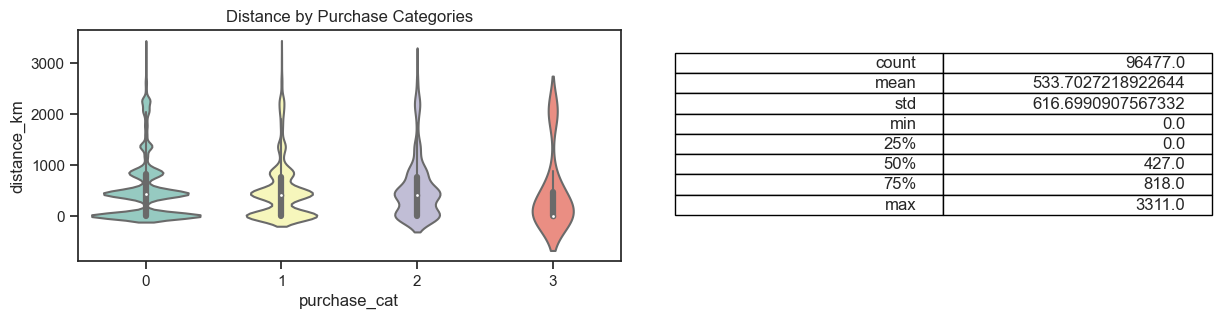

In [33]:
statistics = df['distance_km'].describe().to_dict()
plt.figure(figsize=(7, 3)) 
ax = sns.violinplot(x="purchase_cat", y="distance_km", data=df, palette="Set3")
plotTable(ax, statistics)
plt.title("Distance by Purchase Categories")
plt.show()

Customers tend to prefer to order closer, or within their own state
- Median distance for categories 0, 1, and 2 is about ~500 km, whereas 3 is 0
- Less preferred for further sellers

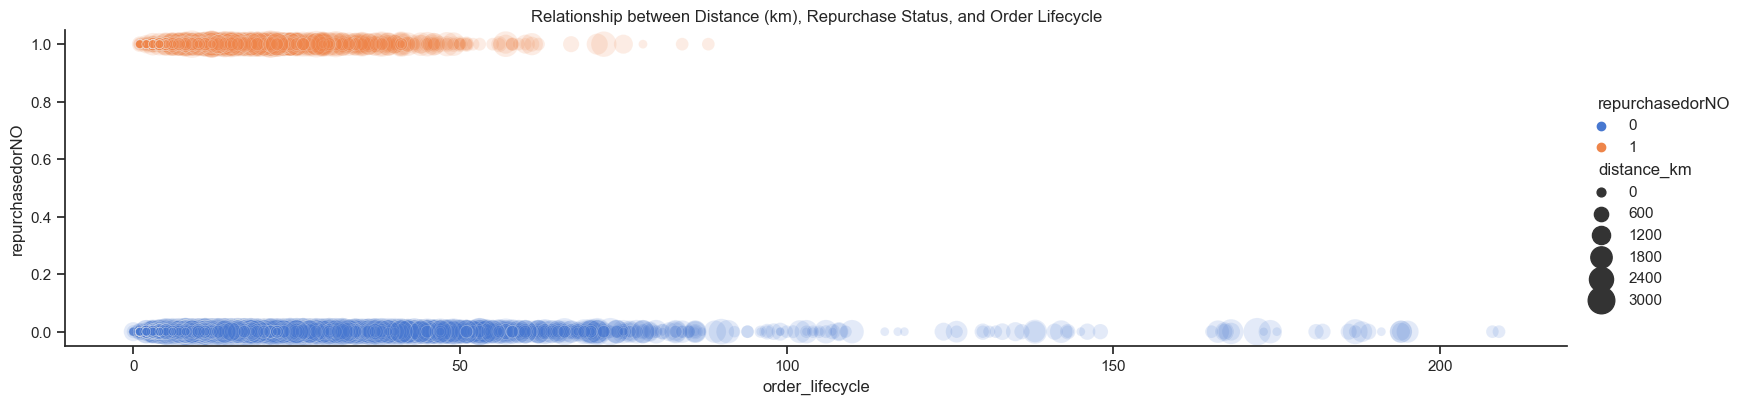

In [34]:
plotReplot(df, "order_lifecycle", "repurchasedorNO",
           "repurchasedorNO", "distance_km",
           "Relationship between Distance (km), Repurchase Status, and Order Lifecycle")

Surprisingly, the longer order lifecycles have short distances too, even for same state deliveries

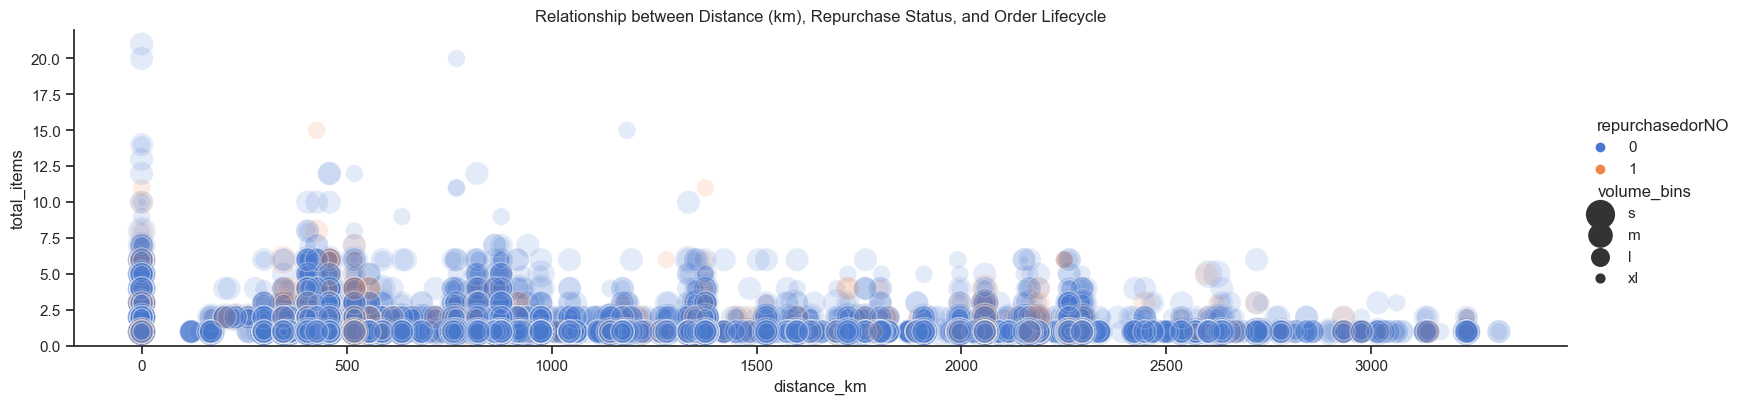

In [35]:
plotReplot(df, "distance_km", "total_items",
           "repurchasedorNO", "volume_bins",
           "Relationship between Distance (km), Total Items, Repeat Buyer, and Product Size")

Surprisingly, customers are willing to purchase serveral large items even despite the distance; some high total_item counts on are on average large sized. 

### Relationship between days

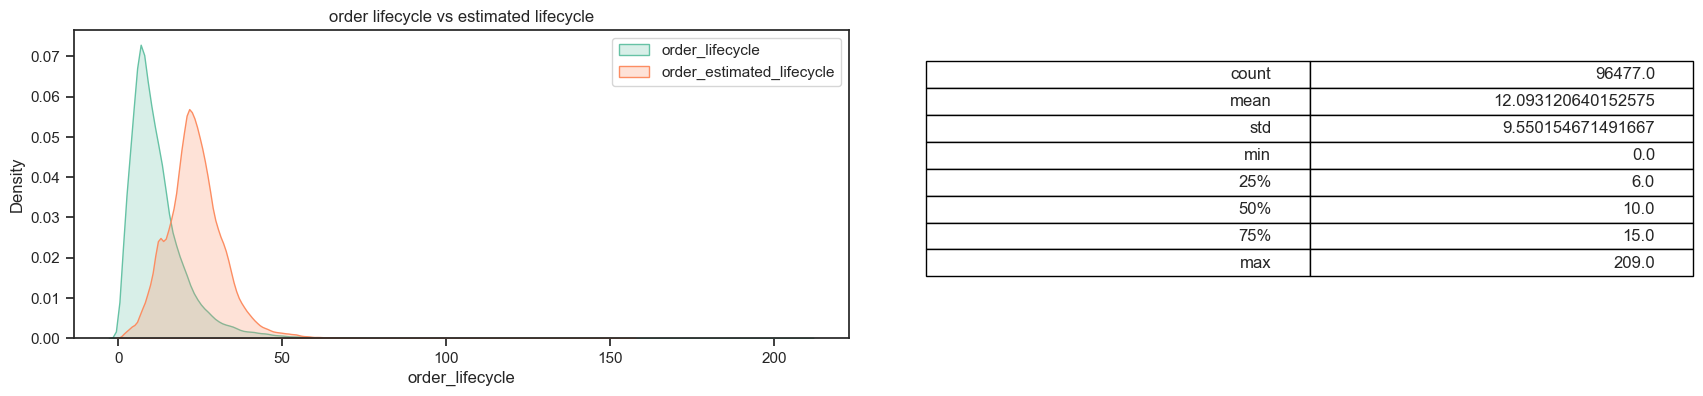

,purchase_cat,order_lifecycle,order_estimated_lifecycle,order_approved_days,order_to_logs_days
0,0,12.109347,23.339469,0.264720,2.729295
1,1,11.903031,23.778663,0.257676,2.843956
2,2,11.610959,24.857534,0.273973,2.867123
3,3,9.000000,19.977778,0.022222,2.088889


In [37]:
days_agg = df.groupby(['purchase_cat', 
                         ]).agg({'order_lifecycle': 'mean',
                                 'order_estimated_lifecycle': 'mean',
                                 'order_approved_days': 'mean',
                                 "order_to_logs_days": 'mean'
                                }).reset_index()

columns_to_plot = ['order_lifecycle', 'order_estimated_lifecycle']
plt.subplots(figsize=(10, 4))

# Plot kdeplot
for column in columns_to_plot:
    ax = sns.kdeplot(df[column], fill=True, 
                label=column)
plt.title("order lifecycle vs estimated lifecycle")
statistics = df['order_lifecycle'].describe().to_dict()
plotTable(ax, statistics)
plt.legend()
plt.show()
days_agg

order_lifecycle
- On avg, it takes 10 days to complete a full order - from purchase timestamp to delivered to customer
- There is an outlier where it took 209 days
- The 75th percentile is 15 days; generally the whole lifecycle is short, and quite fast

purchase_cat
- Between the different purchase categories, customers who are in category 3 have fastest order lifecycles, approved times, and order to logistics.
- One-time customers usually face longer order lifecycles, approved times, and order to logistics

### Relationships with payment types

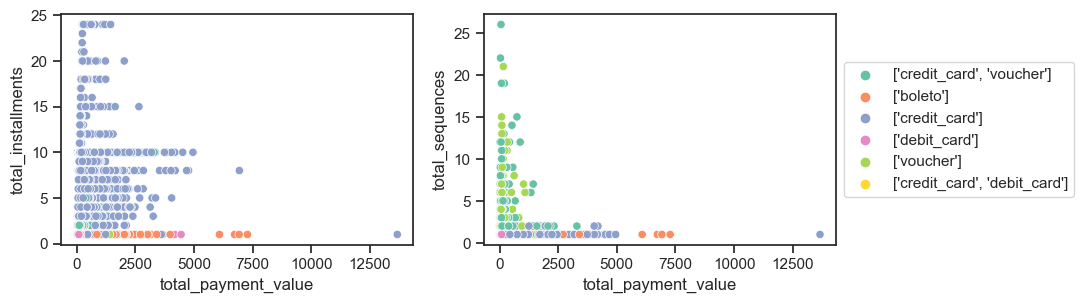

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# Plot scatterplot between payment, and total items
sns.scatterplot(ax=ax[0],data=df, x="total_payment_value", 
                y="total_installments", hue="payment_types",
                legend=False)
sns.scatterplot(ax=ax[1],data=df, x="total_payment_value", 
                y="total_sequences", hue="payment_types",
                legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Customers tend to make more installments with credit cards, however, tend break up their purchases when paying with credit card and vouchers
- Could be due to credit card rebates, multiple vouchers to get the most discounts

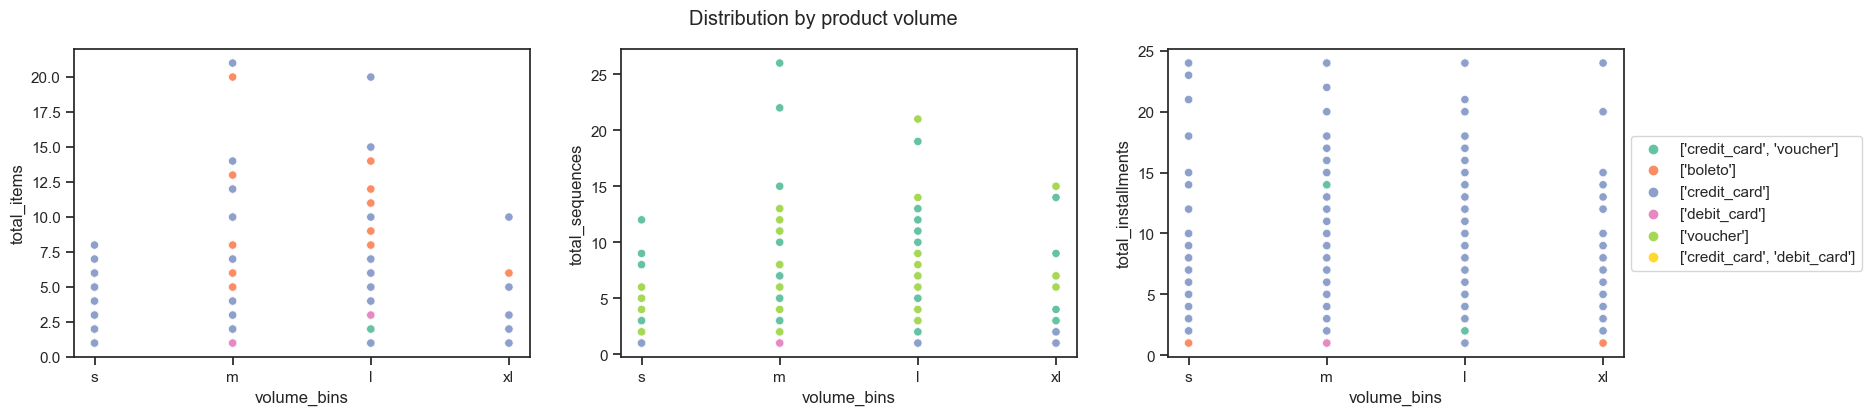

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# Plot scatterplot between payment, and total items
sns.scatterplot(ax=ax[0],data=df, x="volume_bins", 
                y="total_items", hue="payment_types",
                legend=False)
sns.scatterplot(ax=ax[1],data=df, x="volume_bins", 
                y="total_sequences", hue="payment_types",
                legend=False)
sns.scatterplot(ax=ax[2],data=df, x="volume_bins", 
                y="total_installments", hue="payment_types",
                legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle("Distribution by product volume")
plt.show()

Customers prefer to pay for smaller items with credit card, theres more distribution towards m, l and xl products. 

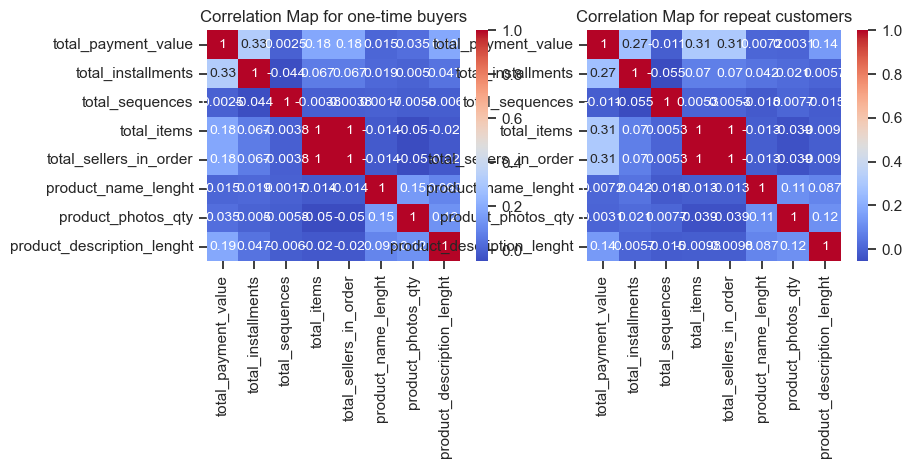

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

In [40]:
# Get df for low and high review scores
repurchase_yes = df[df['repurchasedorNO']==1]
repurchase_no = df[df['repurchasedorNO']==0]

# Filter to columns that most likely attribute to review score
columns = ['total_payment_value', 'total_installments',
           'total_sequences', 'payment_types','total_items',
           'total_sellers_in_order', 'product_name_lenght',
           'product_photos_qty','product_description_lenght'
          ]

# Plot correlation maps
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
plotCorrMap(repurchase_no, columns, 
            "for one-time buyers", axs[0])
plotCorrMap(repurchase_yes, columns, 
            "for repeat customers", axs[1])
plt.show()

- Repeat buyers tend to purchase with lesser installments, but with more total items and more sellers in comparison to one-time buyers
- Product description length has a moderate positive correlation (0.14) with total payment value. Longer the description, more likely to buy?
- Photo qty, description and name have correlation to each other

### Relationship between total items

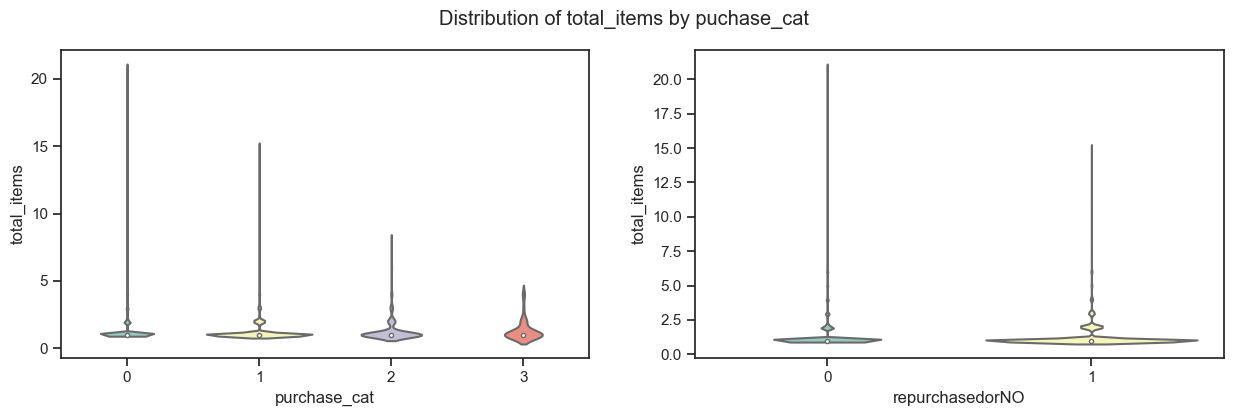

total_items,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,21
purchase_cat,,,,,,,,,,,,,,,,,
0,90.273422,7.525730,1.283184,0.484783,0.193251,0.184416,0.022086,0.006626,0.003313,0.007730,0.002209,0.005521,0.001104,0.002209,0.001104,0.002209,0.001104
1,86.494365,9.657987,2.254178,0.816168,0.291489,0.369219,0.038865,0.000000,0.000000,0.019433,0.038865,0.000000,0.000000,0.000000,0.019433,0.000000,0.000000
2,83.287671,10.136986,3.561644,1.643836,0.410959,0.684932,0.000000,0.273973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,80.000000,13.333333,2.222222,4.444444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [41]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.violinplot(ax=ax[0], x="purchase_cat", y="total_items", data=df, palette="Set3")
sns.violinplot(ax=ax[1], x="repurchasedorNO", y="total_items", data=df, palette="Set3")
plt.suptitle("Distribution of total_items by puchase_cat")
plt.show()
percentages = calculate_pairwise_percentages(df, "total_items", "purchase_cat")
percentages

Customers tend to just purchase one item in their orders, repeat customers often dont buy more than 6 items within the same purchase. Indicating a preference for smaller, more frequent transactions rather than bulk buying.

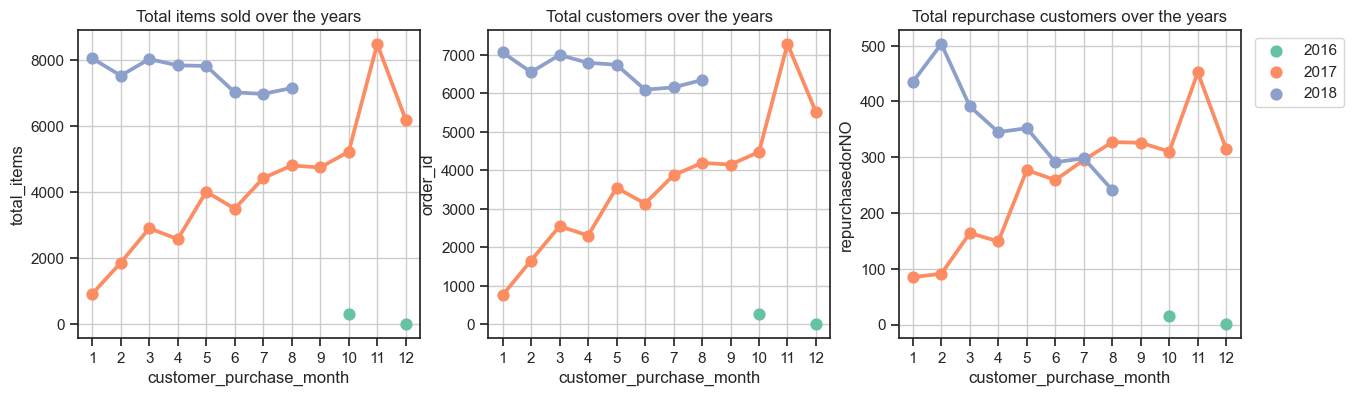

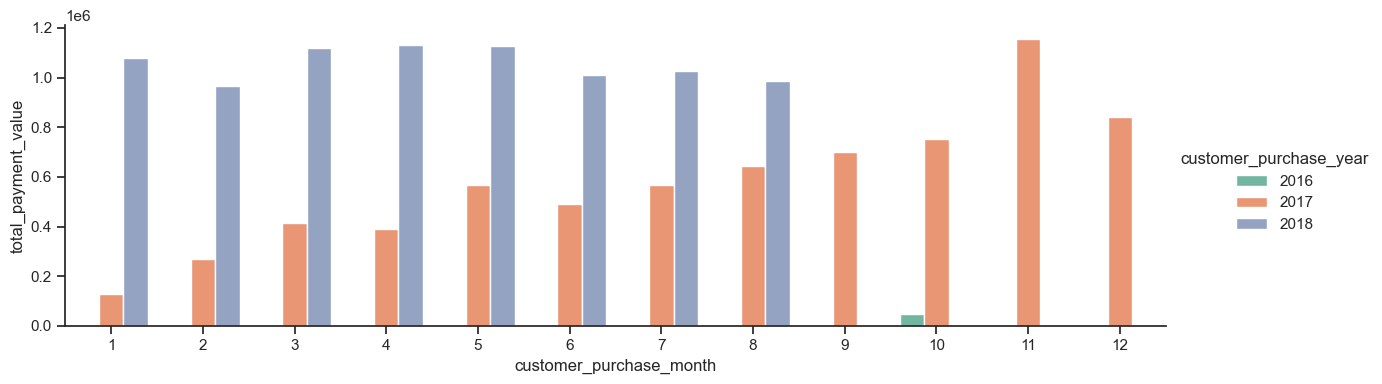

In [42]:
# Create an aggregated dataset to be used with plots
df_agg = df.groupby(['customer_purchase_year', 
                         'customer_purchase_month'
                        ]).agg({'total_items': 'sum',
                                'repurchasedorNO': 'sum',
                                'order_id': 'count',
                                'total_payment_value': 'sum'
                                }).reset_index()
# Plot with point plots
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.pointplot(ax=ax[0], x="customer_purchase_month", y="total_items", 
             hue="customer_purchase_year", data=df_agg).grid(True)
ax[0].set_title("Total items sold over the years")
sns.pointplot(ax=ax[1], x='customer_purchase_month', y='order_id', 
            hue='customer_purchase_year', data=df_agg, markers='o').grid(True)
ax[1].set_title("Total customers over the years")
sns.pointplot(ax=ax[2], x='customer_purchase_month', y='repurchasedorNO', 
            hue='customer_purchase_year', data=df_agg, markers='o').grid(True)
ax[2].set_title("Total repurchase customers over the years")

catplot = sns.catplot(x='customer_purchase_month', y='total_payment_value', 
            hue='customer_purchase_year', data=df_agg, kind='bar', 
            height=4, aspect=3, dodge=True)

ax[0].legend().remove()
ax[1].legend().remove()
ax[2].legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.show()

Between total items, total customers, and total sales; they are directly proportionate. However, in 2018, February had record number of repeat customers ~500, following March saw a significant dip in reeat buyers in a continuous downward trend. Festive periods like Christmas and New Years (December) dont seem cause significant spikes; in 2016, items sales dipped from ~400 items sold in October to  ~1 item sold in December

## 4. Data transformation

Dropping features for the next step in the pipeline - Data Preprocessing

In [43]:
features_to_drop = ['order_status','seller_state','customer_unique_id','customer_state',
                    'purchase_cat','customer_purchase_count', 'review_comment_title',
                    'review_comment_message','answer_days_taken']
df.drop(columns=features_to_drop, inplace=True)

In [53]:
df['review_score'] = df['review_score'].fillna(0)

In [55]:
df.columns

Index(['order_id', 'customer_id', 'customer_purchase_month',
       'customer_purchase_year', 'order_lifecycle',
       'order_estimated_lifecycle', 'order_approved_days',
       'order_to_logs_days', 'total_items', 'total_sellers_in_order',
       'product_category_name', 'distance_km', 'total_price',
       'total_freight_cost', 'product_photos_qty', 'product_name_lenght',
       'product_description_lenght', 'product_volume', 'payment_types',
       'total_installments', 'total_payment_value', 'total_sequences',
       'total_reviews', 'review_score', 'repurchasedorNO', 'volume_bins'],
      dtype='object')

# Conclusion

Through the EDA, relationships and correlations could be uncovered, allowing impactful insights to be made towards understanding customer's preferences, which can result in a better business model and helping Olist find better strategies to entice repeat buyers.

- Most features have low correlation with purchase_cat due to the nature of having many different features and attributes to factor in. 
- Bias and skewness is easily introduced due to the sheer number one-time customers domineering the dataset
- Customers prefer to purchase medium-sized cheap household items, with purchase habits of making one order per transaction, from single seller close to or within their state. Payment made by credit card, however if they have vouchers - they would prefer to split into sequences. Customers also like to purchase from a single category rather than multiple

In [57]:
df.to_csv("transformedOlist",index=False)